# Pet Finder

In [38]:
import pandas as pd
import numpy as np
import os
import shutil
import pathlib
from matplotlib import pyplot as plt
import PIL

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.applications.resnet import ResNet50, decode_predictions
from keras_preprocessing import image

Our project is based on a Kaggle competition called PetFinder. We chose this particular project as it has a lot of images and other relevant information related to these pictures. Thus, the data from this competition can be used for different types of applications. Our project tries to achieve three types of classification using Convolutional Neural Network: a dog/cat classifier, a dog breed classifier and a cat breed classifier using methods from the tensorflow library.

#### Data manipulation

Our data is stored in a csv file. We will load that file and do some cleanups, such as removing unnecessary columns and unsuitable entries. These entries are those that have more animals in a single entry and those that do not have any photos.

In [5]:
def create_directory(path):
    if os.path.exists(path) and os.path.isdir(path):
        shutil.rmtree(path)
    os.mkdir(path)

In [6]:
df = pd.read_csv('./train.csv')
df = df.query('Quantity == 1 & PhotoAmt > 0')

We chose to discard the other columns as they include irelevant data such as age, whether they were adopted, etc. We only need the PetID and Breed1 columns to be able to link pictures with species and breeds later on in the project.

In [7]:
df = df[['PetID', 'Breed1']]
df.rename(columns={'PetID': 'PetID', 'Breed1': 'Breed'}, inplace=True)
df.shape

(11330, 2)

With our data separated, let's take a look at the breeds and how they vary across cats and dogs.

In [8]:
breed_df = pd.read_csv('./BreedLabels.csv')
breed_df=pd.DataFrame(breed_df)
breed_df.shape

(307, 3)

From the Breed Labels csv file, we know that we have 307 different breeds.
On the next step, let's take a look at how many of them are dog breeds and how many are cat breeds.

Number of dog breeds: 

In [9]:
dog_breeds = breed_df.query(' Type == 1 ')
dog_breeds.shape[0]

241

Number of cat breeds:

In [10]:
cat_breeds = breed_df.query(' Type == 2 ')
cat_breeds.shape[0]

66

In [11]:
df.dtypes

PetID    object
Breed     int64
dtype: object

In [12]:
breed_df = breed_df.astype(str)
breed_df.dtypes

BreedID      object
Type         object
BreedName    object
dtype: object

In [13]:
df['Breed']=df['Breed'].astype(str)

In [14]:
df.head()

,PetID,Breed
0,86e1089a3,299
1,6296e909a,265
2,3422e4906,307
3,5842f1ff5,307
4,850a43f90,307


In the following code we iterate through the dataframe and for each entry check what species the animal is and update the Species column for that row. Also, because our original dataframe used codes to identify animals to their breeds through an additional csv file, we chose to update the Breed column for easier manipulation of images.

In [15]:
for index, row in df.iterrows():
    if row['Breed'] in breed_df['BreedID'].values:
        #if Type from breed_df is '1' Species is dog else cat
        if breed_df[breed_df['BreedID'] == row['Breed']]['Type'].values[0] == '1':
            df.at[index, 'Species'] = 'dog'
        else:
            df.at[index, 'Species'] = 'cat'
        df.loc[index, 'Breed'] = breed_df[breed_df['BreedID'] == row['Breed']]['BreedName'].values[0]

In [16]:
df.head()

,PetID,Breed,Species
0,86e1089a3,Tabby,cat
1,6296e909a,Domestic Medium Hair,cat
2,3422e4906,Mixed Breed,dog
3,5842f1ff5,Mixed Breed,dog
4,850a43f90,Mixed Breed,dog


In [17]:
df.query('Species == "dog" & Breed != "Mixed Breed"').shape[0]

1915

With our data frame properly manipulated, we can now split the images in directories for cats and dogs.

train_images_path = './train_images'
out_path = './train/'

create_directory('./train/dogs')
create_directory('./train/cats')

for _, row in df.iterrows():
    if not row['Species'] in ['dog', 'cat']:
        continue

    files = os.listdir(train_images_path)
    pet_id_images = [ os.path.join(train_images_path, image) for image in files if os.path.isfile(os.path.join(train_images_path, image)) and row['PetID'] in image ]
    for image in pet_id_images:
        shutil.copy(image, os.path.join(out_path, row['Species'] + 's'))

We plotted the distribution of breeds in our dataset in two ways for easy understanding of the size and quality of our data.

<AxesSubplot:xlabel='Species'>

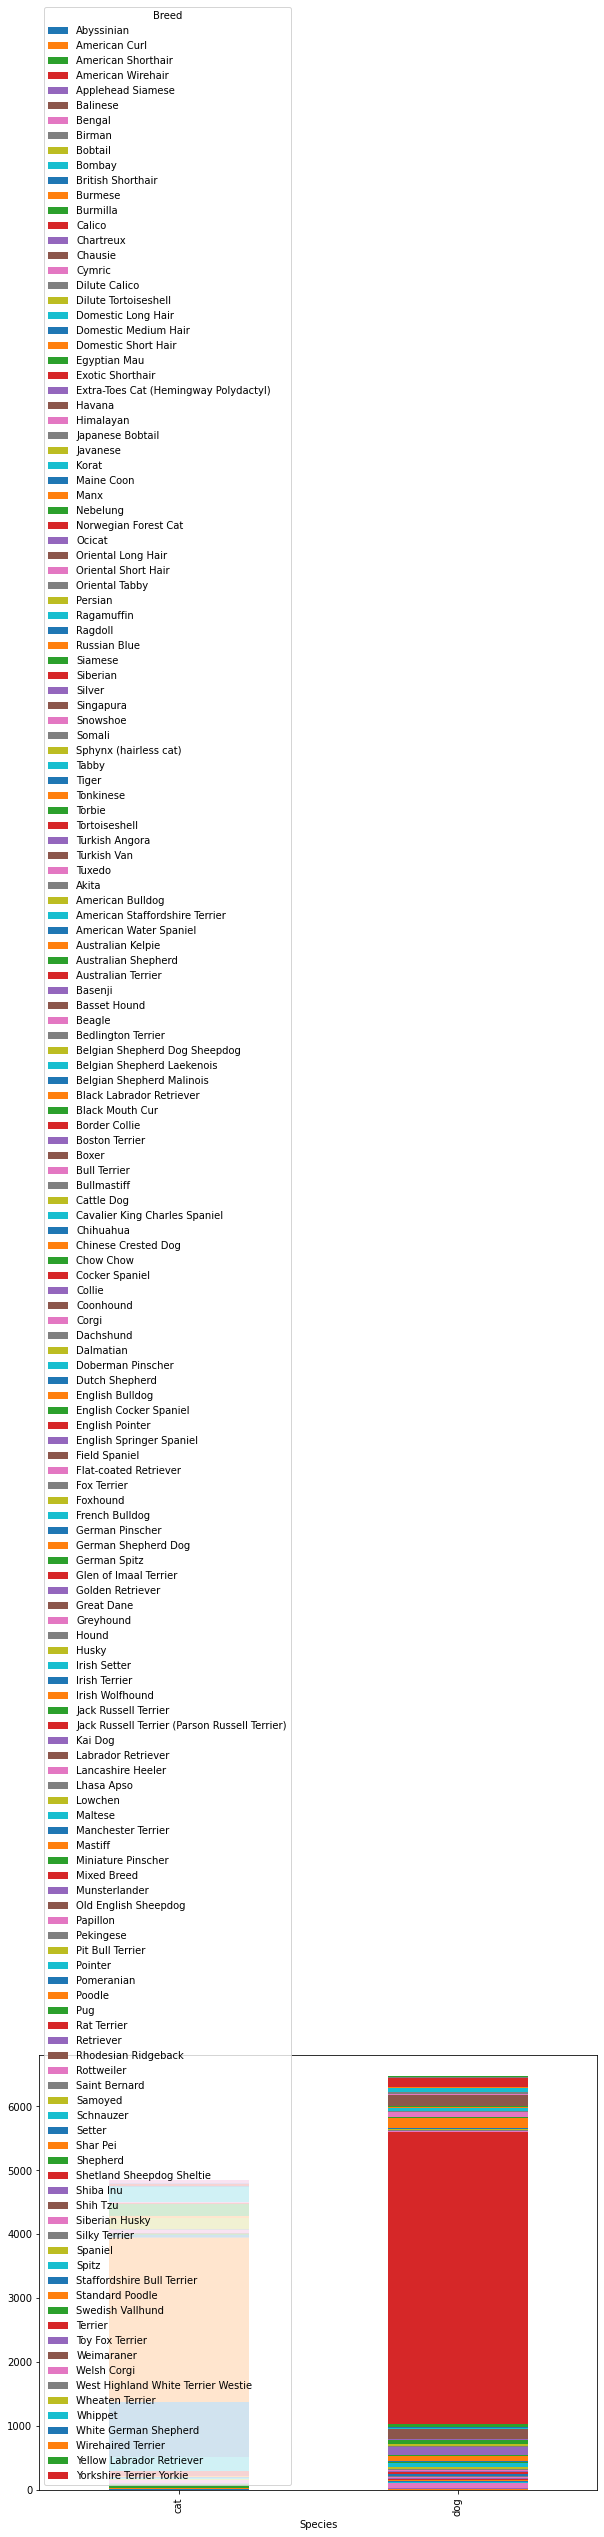

In [18]:
df.groupby(['Species', 'Breed']).count()['PetID'].unstack().plot(kind='bar', stacked=True, figsize=(10, 8))

<AxesSubplot:xlabel='Breed'>

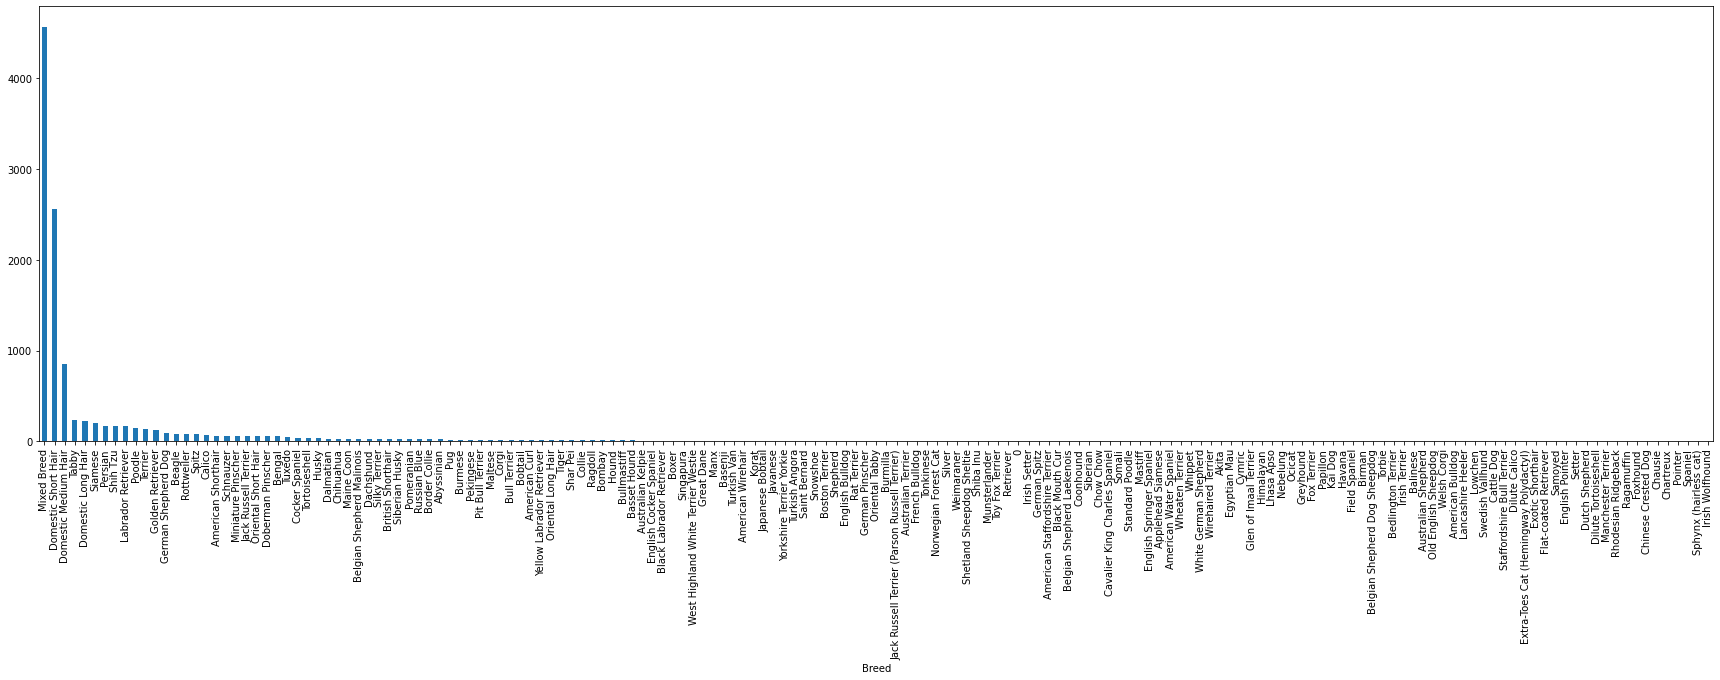

In [19]:
#plot the distribution of the number of entries per breed
df.groupby(['Breed']).count()['PetID'].sort_values(ascending=False).plot(kind='bar', figsize=(30, 8))

In [66]:
pd.DataFrame(df.groupby(['Breed']).count()['PetID'].sort_values(ascending=False)).query('PetID > 100')

,PetID
Breed,
Mixed Breed,4564
Domestic Short Hair,2562
Domestic Medium Hair,855
Tabby,240
Domestic Long Hair,221
Siamese,198
Persian,173
Shih Tzu,168
Labrador Retriever,167


With our data ready, let's begin preparing our dataset.

We define some constants for our training model. After that we split the training and validation dataset into an 80-20 distribution. Thus, the final dataset will be 22.7k for training and 5.6k for validation.

In [20]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = pathlib.Path('./train')

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 41710 files belonging to 2 classes.
Using 33368 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 41710 files belonging to 2 classes.
Using 8342 files for validation.


In [23]:
normalization_layer = layers.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9198986


This is the actual model creation. We rescale each layer to be the size we have defined before. The Conv2D argument is a 2D convolutional layer, used to create a convolution kernel that will be used to create tensor outputs. The activation function we chose to use is ReLU(Rectified Linear Unit), because it does not activate all the neurons at the same time thus resulting in a much lower computational time, especially in very big data applications. MaxPooling2D downsamples the input along the height and width dimensions by taking the maximum value over an input window that moves across the image in a shifting movement. The flatten operator is used to transform the resulting image into an array. Dense creates a layer with the neurons fully connected.

In [25]:
class_names = train_ds.class_names
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

This is a summary of the number of trainable params after each of the operators has done its job. As we can see, at the end, our model ends up with almost 4 million trainable params.

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

This is where we train the model that we have previously defined. We use 10 epochs.

In [28]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1043/1043 [==============================] - 308s 294ms/step - loss: 0.6418 - accuracy: 0.6405 - val_loss: 0.5826 - val_accuracy: 0.6918
Epoch 2/10
1043/1043 [==============================] - 275s 264ms/step - loss: 0.5501 - accuracy: 0.7195 - val_loss: 0.5480 - val_accuracy: 0.7224
Epoch 3/10
 798/1043 [=====================>........] - ETA: 1:00 - loss: 0.4992 - accuracy: 0.7590

KeyboardInterrupt: 

We plot the Accuracy and Loss for both Training and Validation to show how our program's evolving throughout the training process.

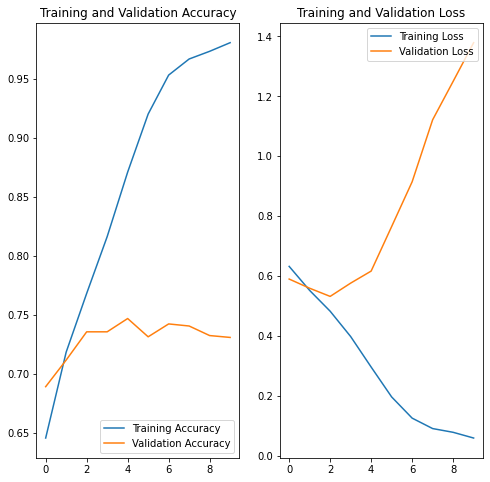

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
711/711 [==============================] - 478s 670ms/step - loss: 0.6431 - accuracy: 0.6304 - val_loss: 0.6526 - val_accuracy: 0.6264
Epoch 2/15
711/711 [==============================] - 485s 682ms/step - loss: 0.5936 - accuracy: 0.6829 - val_loss: 0.5725 - val_accuracy: 0.6969
Epoch 3/15
711/711 [==============================] - 491s 691ms/step - loss: 0.5697 - accuracy: 0.7019 - val_loss: 0.5592 - val_accuracy: 0.7080
Epoch 4/15
711/711 [==============================] - 494s 695ms/step - loss: 0.5529 - accuracy: 0.7185 - val_loss: 0.5459 - val_accuracy: 0.7203
Epoch 5/15
711/711 [==============================] - 497s 698ms/step - loss: 0.5378 - accuracy: 0.7301 - val_loss: 0.5406 - val_accuracy: 0.7244
Epoch 6/15
711/711 [==============================] - 500s 703ms/step - loss: 0.5264 - accuracy: 0.7364 - val_loss: 0.5210 - val_accuracy: 0.7358
Epoch 7/15
711/711 [==============================] - 509s 716ms/step - loss: 0.5104 - accuracy: 0.7491 - val_loss: 0.5180 -

This time we have chosen to do 15 epochs and as we can see from the plots down below, the accuracy and loss graphs don't jump as much.

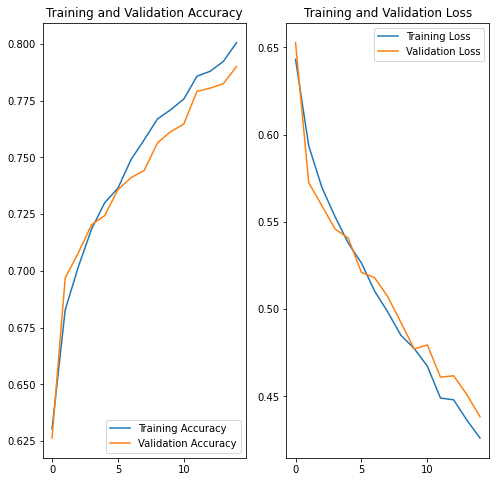

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We tested this classifier with one picture of a dog, and our program, after being trained predicted that it is a dog with a confidence of almost 64%

In [ ]:
test_images_path = './test_images'

data_dir = pathlib.Path('test_images/fe42c1ee7-3.jpg')
display_image = PIL.Image.open(str(data_dir))
display_image.show()

img = tf.keras.utils.load_img(
    data_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 2s 2s/step
This image most likely belongs to dogs with a 63.71 percent confidence.



(viewnior:26543): Gtk-WARNING **: 18:57:43.749: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.749: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.749: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.758: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.759: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.759: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.760: Unable to locate theme engine in module_path: "murrine",


Having already classified cats and dogs, a further interesting topic would be a breed classification among the species.

#### Breed classification

We already altered our dataframe to contain the breeds for us, so the data manipulation is no longer required. All we need to do now, is create our training directories.

First of all, we will create the top-level directories.

In [71]:
train_images_path = './train_images'
out_path = './train_breeds'

create_directory(f'{out_path}')
create_directory(f'{out_path}/dogs')
create_directory(f'{out_path}/cats')

We split the cats and dogs images into two big directories and them every breed of cat and dog into subdirectories of their species' directory for our model to be able to access the class names that it will use when training the model furter ahead.

In [72]:
import string

def remove_whitespaces(name):
    return name.translate({ord(c): None for c in string.whitespace})

for _, row in df.iterrows():
    breed = row['Breed']
    #if breed in Mixed Breed, Domestic Short Hair, Domestic Medium Hair, Tabby, Domestic Long Hair, Siamese, Persian, Shi Tzu, Labrador Retriever, Poodle, Terrier, Golden Retriever
    if breed in ['Mixed Breed', 'Domestic Short Hair', 'Domestic Medium Hair', 'Tabby', 'Domestic Long Hair', 'Siamese', 'Persian', 'Shi Tzu', 'Labrador Retriever', 'Poodle', 'Terrier', 'Golden Retriever']:
        files = os.listdir(train_images_path)
        pet_id_images = [ os.path.join(train_images_path, image) for image in files if os.path.isfile(os.path.join(train_images_path, image)) and row['PetID'] in image ]
        for image in pet_id_images:
            if not row['Species'] in ['dog', 'cat']:
                continue

            dir_path = os.path.join(out_path, str(row['Species']) + 's', remove_whitespaces(str(row['Breed']).replace("/", "_")))
            
            if not (os.path.exists(dir_path) and os.path.isdir(dir_path)):
                create_directory(dir_path)
            shutil.copy(image, dir_path)


KeyboardInterrupt: 

In [ ]:
dog_data_dir = pathlib.Path('./train_breeds/dogs')

As with the cat/dog classifier we have to split the images into train and validation images. First we split the dog images, and the result is 18.1k images corresponding to 100 breeds have been chosen to be the training images, and the rest will be used to validate our models.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dog_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22720 files belonging to 107 classes.
Using 18176 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dog_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22720 files belonging to 107 classes.
Using 4544 files for validation.


As with the previous classifier, we have to rescale our images to bring their values from between 0 and 255 to between 0 and 1.

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [ ]:
class_names[:10:]

['Akita',
 'AmericanBulldog',
 'AmericanStaffordshireTerrier',
 'AmericanWaterSpaniel',
 'AustralianKelpie',
 'AustralianShepherd',
 'AustralianTerrier',
 'Basenji',
 'BassetHound',
 'Beagle']

We used the same training algorithm for the dog breed classifier as we have used for the dog/cat classifier

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

After defining our model we have 4 million trainable params for our neural network.

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_17 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
568/568 [==============================] - 425s 744ms/step - loss: 1.6822 - accuracy: 0.7099 - val_loss: 1.6117 - val_accuracy: 0.7163
Epoch 2/10
568/568 [==============================] - 446s 786ms/step - loss: 1.6309 - accuracy: 0.7110 - val_loss: 1.5884 - val_accuracy: 0.7163
Epoch 3/10
568/568 [==============================] - 453s 796ms/step - loss: 1.6164 - accuracy: 0.7111 - val_loss: 1.5685 - val_accuracy: 0.7163
Epoch 4/10
568/568 [==============================] - 464s 816ms/step - loss: 1.6006 - accuracy: 0.7110 - val_loss: 1.5702 - val_accuracy: 0.7161
Epoch 5/10
568/568 [==============================] - 453s 797ms/step - loss: 1.5953 - accuracy: 0.7112 - val_loss: 1.5587 - val_accuracy: 0.7163
Epoch 6/10
568/568 [==============================] - 456s 802ms/step - loss: 1.5777 - accuracy: 0.7109 - val_loss: 1.5581 - val_accuracy: 0.7165
Epoch 7/10
568/568 [==============================] - 459s 808ms/step - loss: 1.5661 - accuracy: 0.7109 - val_loss: 1.5501 -

We plot both the Accuracy and Loss graphs for the two datasets, the Training and the Validation dataset.

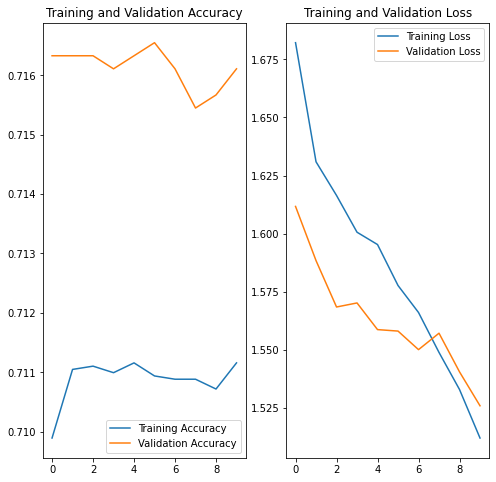

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_images_path = './test_images'

data_dir = pathlib.Path('train_breeds/dogs/Dalmatian/0ab8ae91b-1.jpg')
display_image = PIL.Image.open(str(data_dir))
display_image.show()

img = tf.keras.utils.load_img(
    data_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 451ms/step
This image most likely belongs to MixedBreed with a 77.21 percent confidence.



(viewnior:40811): Gtk-WARNING **: 21:04:22.422: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.422: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.422: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.424: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.424: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.424: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.424: Unable to locate theme engine in module_path: "murrine",


As we can see, the training did not go to well, and that is mostly due to certain breeds having significantly more images than others.
So, for improving our accuracy, we will reduce our dataset to the four breeds that have the most images.

In [ ]:
cat_data_dir = pathlib.Path('./train_breeds/cats')

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  cat_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18990 files belonging to 57 classes.
Using 15192 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  cat_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18990 files belonging to 57 classes.
Using 3798 files for validation.


In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.045969523 0.6603486


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
class_names[:10:]

['Abyssinian',
 'AmericanCurl',
 'AmericanShorthair',
 'AmericanWirehair',
 'AppleheadSiamese',
 'Balinese',
 'Bengal',
 'Birman',
 'Bobtail',
 'Bombay']

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
475/475 [==============================] - 321s 673ms/step - loss: 1.8346 - accuracy: 0.5375 - val_loss: 1.7671 - val_accuracy: 0.5424
Epoch 2/10
475/475 [==============================] - 351s 737ms/step - loss: 1.7784 - accuracy: 0.5421 - val_loss: 1.7729 - val_accuracy: 0.5419
Epoch 3/10
475/475 [==============================] - 347s 730ms/step - loss: 1.7285 - accuracy: 0.5410 - val_loss: 1.7923 - val_accuracy: 0.5390
Epoch 4/10
475/475 [==============================] - 350s 736ms/step - loss: 1.5824 - accuracy: 0.5518 - val_loss: 1.9127 - val_accuracy: 0.5187
Epoch 5/10
475/475 [==============================] - 352s 741ms/step - loss: 1.2826 - accuracy: 0.6027 - val_loss: 2.3884 - val_accuracy: 0.4779
Epoch 6/10
475/475 [==============================] - 350s 737ms/step - loss: 0.8687 - accuracy: 0.7112 - val_loss: 3.4950 - val_accuracy: 0.4523
Epoch 7/10
475/475 [==============================] - 349s 735ms/step - loss: 0.5416 - accuracy: 0.8098 - val_loss: 4.4326 -

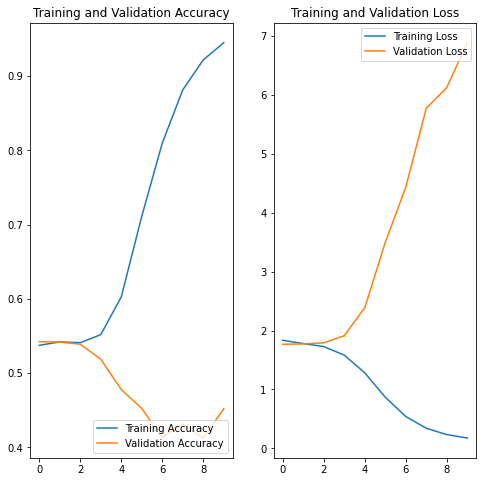

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_images_path = './test_images'

data_dir = pathlib.Path('train_breeds/cats/Bobtail/3d939327d-2.jpg')
display_image = PIL.Image.open(str(data_dir))
display_image.show()

img = tf.keras.utils.load_img(
    data_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


(viewnior:37688): Gtk-WARNING **: 19:33:05.639: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.639: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.639: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.642: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.642: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.642: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.642: Unable to locate theme engine in module_path: "murrine",


1/1 [==============================] - 1s 1s/step
This image most likely belongs to DomesticShortHair with a 94.20 percent confidence.


In [39]:
resModel = ResNet50(weights='imagenet')
def evaluate(img_fname):
    img = image.load_img(img_fname, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    preds=resModel.predict(img_array)
    print('Predicted:', decode_predictions(preds, top=5)[0])
    plt.imshow(img)

1/1 [==============================] - 0s 71ms/step
Predicted: [('n02110185', 'Siberian_husky', 0.88059324), ('n02109961', 'Eskimo_dog', 0.10518149), ('n02110063', 'malamute', 0.012427489), ('n02090622', 'borzoi', 0.00097209), ('n03218198', 'dogsled', 0.0001837694)]


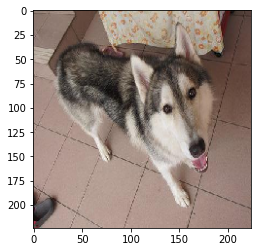

In [54]:
evaluate('./train_breeds/dogs/Husky/0ff7245bd-4.jpg')

1/1 [==============================] - 0s 65ms/step
Predicted: [('n02088238', 'basset', 0.7604932), ('n02100735', 'English_setter', 0.13309759), ('n02088632', 'bluetick', 0.02229268), ('n02092339', 'Weimaraner', 0.013456269), ('n02110341', 'dalmatian', 0.01004415)]


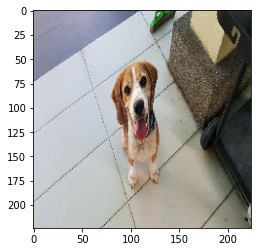

In [58]:
evaluate('./train_breeds/dogs/Beagle/3d8a35224-6.jpg')

1/1 [==============================] - 0s 66ms/step
Predicted: [('n02108089', 'boxer', 0.178962), ('n02096585', 'Boston_bull', 0.16606681), ('n02108915', 'French_bulldog', 0.12815197), ('n02088364', 'beagle', 0.09412934), ('n02093428', 'American_Staffordshire_terrier', 0.058565307)]


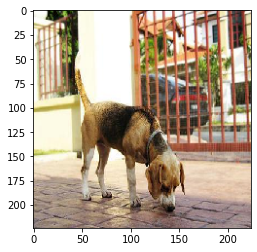

In [59]:
evaluate('./train_breeds/dogs/Beagle/f663a91e8-8.jpg')

1/1 [==============================] - 0s 65ms/step
Predicted: [('n02111889', 'Samoyed', 0.455462), ('n02111500', 'Great_Pyrenees', 0.15315324), ('n02104029', 'kuvasz', 0.12945914), ('n02114548', 'white_wolf', 0.11045762), ('n02120079', 'Arctic_fox', 0.022408321)]


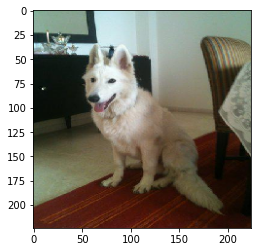

In [60]:
evaluate('./train_breeds/dogs/WhiteGermanShepherd/58132cc85-1.jpg')